In [1]:
import sys
sys.path.append('./')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import os
from typing import Union

In [3]:
import torch as th
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

In [4]:
from dataset import ImageDataset, DataModule
from config import Config
import tokenizer
import utils
import model

In [5]:
df = pd.read_csv(os.path.join(Config.data_dir, 'Train.csv'), nrows=1000)
tok = tokenizer.Tokenizer()
dm = DataModule(df=df, tokenizer=tok)
dm.setup()

for data in dm.val_dataloader():
    images = data['img']
    labels = data['label']
    print(images.shape)
    print(labels.shape)
    break

INFO:root:Training on 800 and validating on 200


torch.Size([64, 3, 90, 282])
torch.Size([64, 10])


In [6]:
tfms = transforms.Compose([
    transforms.Resize(size=(Config.img_H, Config.img_W)),
])
net = model.Model(pretrained=True, transform=tfms).cuda()
# print(model)

INFO:root:Using resnet18 as features extractor


In [7]:
for batch_idx, data in enumerate(dm.val_dataloader()):
    images = data['img']
    labels = data['label']
    log_probs, beam_results, out_lens, loss = net(inputs=images.cuda(),
                                                targets=labels.cuda())
    
    pred_ids, pred_texts, target_texts = net.batch_decode(
                                                            tokenizer=tok,
                                                            beam_results=beam_results,
                                                            out_lens=out_lens,
                                                            targets=labels,
                                                            select_index=0
    )

    
    image = utils.view_sample(images=images, labels=labels, predictions=pred_texts, return_image=True, show=False)
    
    break

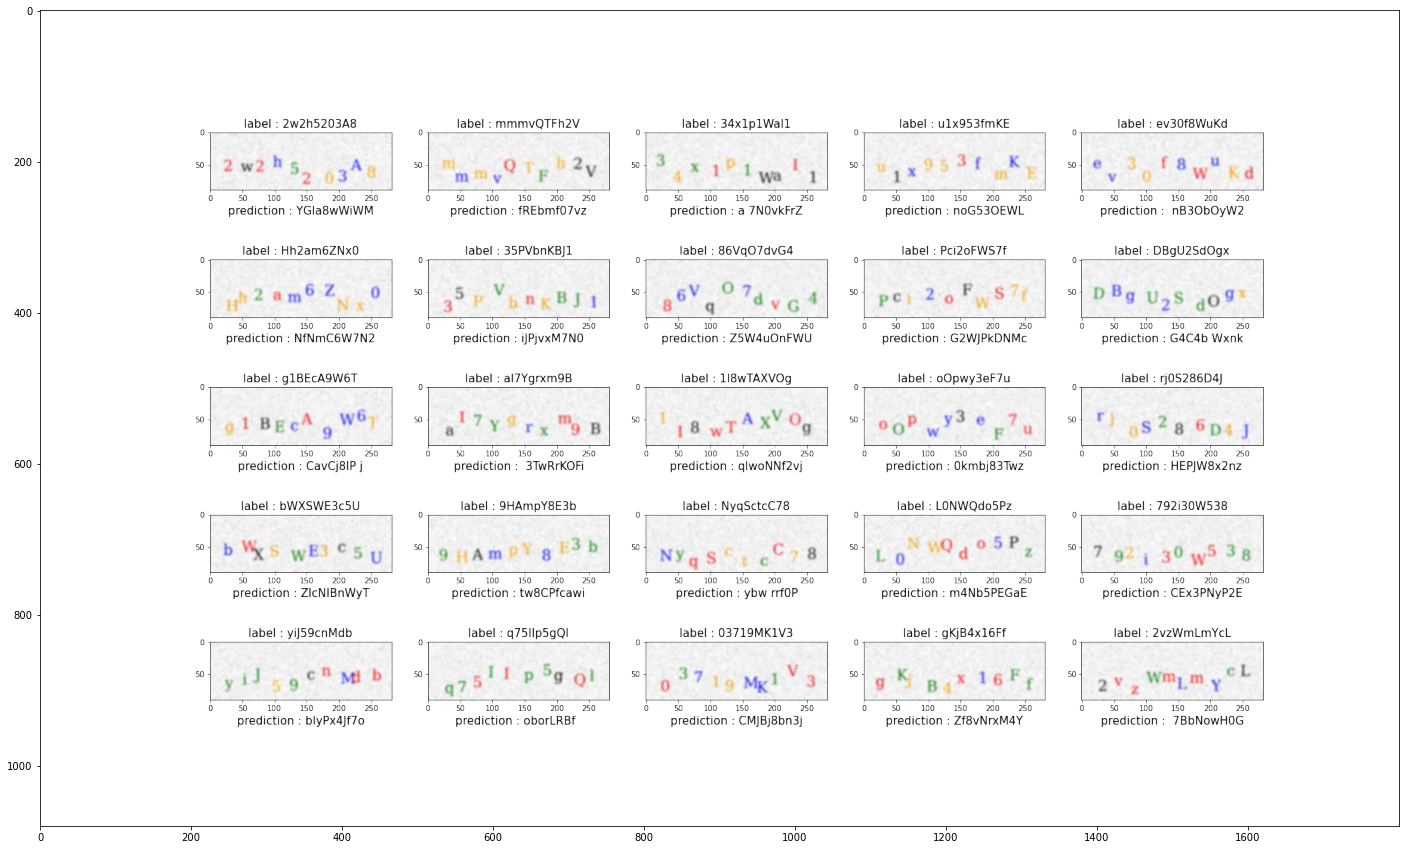

In [8]:
plt.figure(figsize=(25, 15))
plt.imshow(image)
plt.show()

In [9]:
writer = SummaryWriter(log_dir=os.path.join(Config.logs_dir, 'plots'))

In [10]:
writer.add_image(tag='predictions_grid', img_tensor=np.array(image), dataformats='HWC')